In [ ]:
#Libraries
import os
import cv2 #cv2 for image manipulation
from google.colab.patches import cv2_imshow # import new function instead
import matplotlib.pyplot as plt #for displaying images


import numpy as np
import matplotlib.image as mpimg
from scipy import ndimage # multidimensional image processing
from skimage.color import rgb2hsv # image processing algorithms , RGB -> Histogram

import skimage.util as util
from skimage.exposure import rescale_intensity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


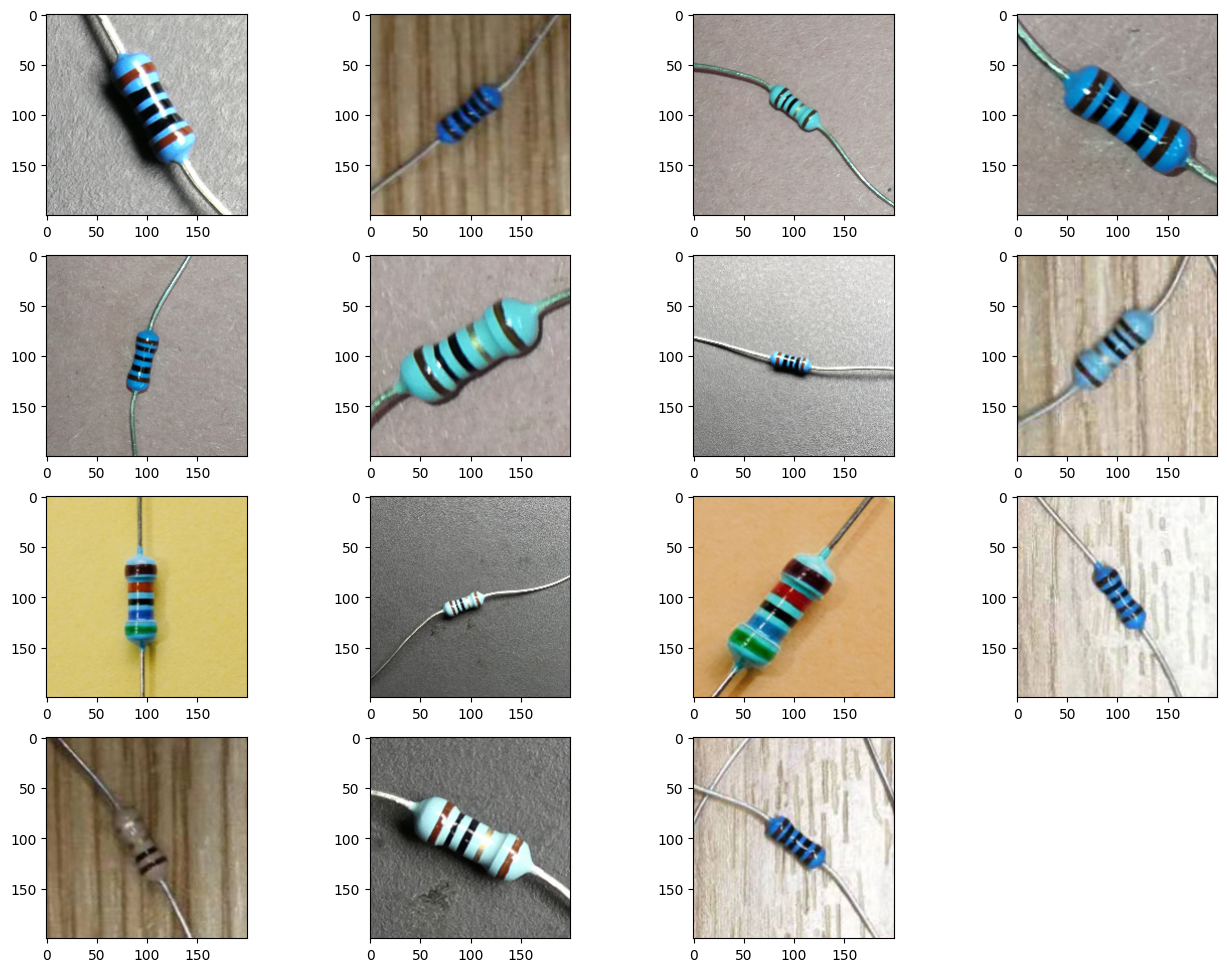

In [ ]:

walking_path = os.walk("/content/drive/MyDrive/Images/Data_set/") #starting off the walk directory
walking_path = list(walking_path)#converting the generator to a list


dataSet= []   #our image list
for items in walking_path: #going through each of the images
  root = items[0] #getting the root of the file
  files = items[2] #getting the file
  for file in files:
    if file.endswith(".jpg"): #if its an image file
      dataSet.append(os.path.join(root,file)) #add the file to the dataSet list

plt.figure(figsize=(16, 12))
k=1
for i in dataSet:

  img = cv2.imread(str(i)) #for each image in the data set
  img = cv2.resize(img, (200, 200))
  dataSet[k-1] = img
  plt.subplot(4,4,k)
  plt.imshow(img[:,:,::-1])
  k+=1







Object Identification

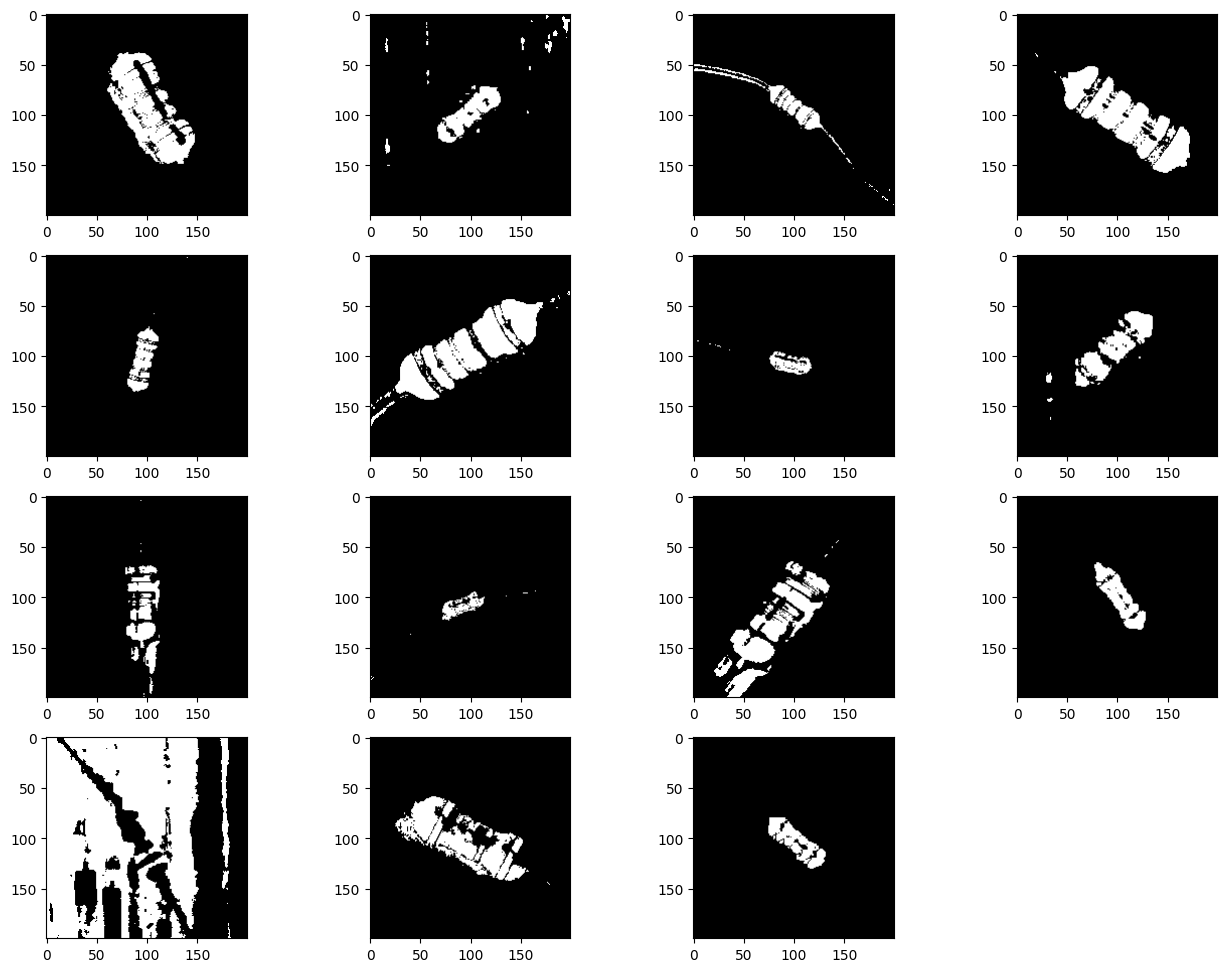

In [ ]:
hsv_dataSet = []
grey_dataSet = []
located_dataSet = []
cleaned_hsv_dataSet = []
area_of_focus_dataSet = []
k=1
plt.figure(figsize=(16, 12))
for i in dataSet:
  hsv_img = rgb2hsv(i)
  grey_dataSet.append(cv2.cvtColor(i, cv2.COLOR_RGB2GRAY))
  hsv_c = (255*hsv_img[:,:,1]).astype(np.uint8) # scale data from [0, 1] to [0, 255] and convert to uint8 type
  thresh_hsv, bw_hsv = cv2.threshold(hsv_c, thresh=128, maxval=255, type=cv2.THRESH_OTSU) # manually selected threshold, low values to 255
  hsv_dataSet.append(bw_hsv)

  plt.subplot(4,4,k)
  plt.imshow(bw_hsv,cmap="gray")
  k+=1



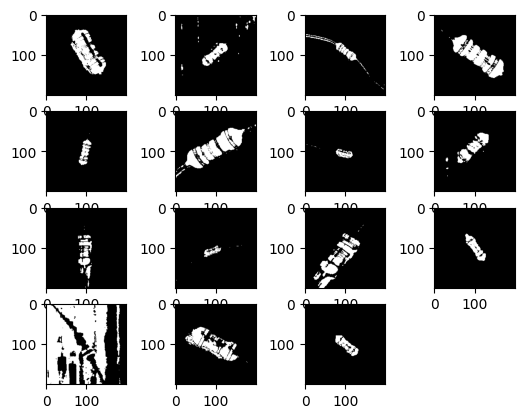

In [ ]:
k = 1
for i in hsv_dataSet:
  plt.subplot(4,4,k)
  plt.imshow(i,cmap="gray")
  k+=1


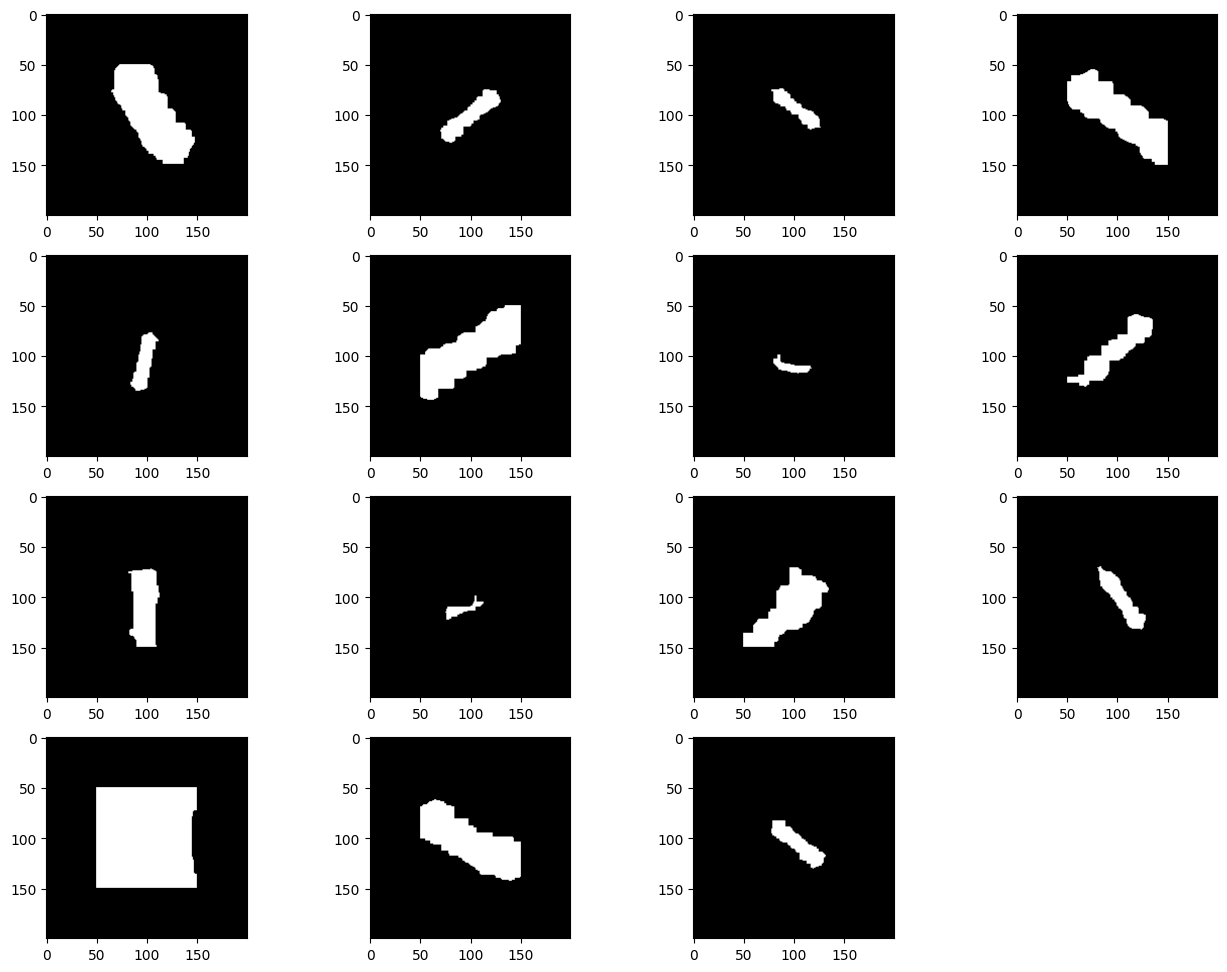

In [ ]:
k=1
plt.figure(figsize=(16, 12))

for i in hsv_dataSet:
  # create a structuring element
  kernel = np.ones((2,2),np.uint8)
  # closing
  closing = cv2.morphologyEx(i, cv2.MORPH_CLOSE, kernel, iterations=1)
   # erosion
  kernel = np.ones((4,4),np.uint8)
  erosion = cv2.erode(closing,kernel,iterations = 1)
  # closing
  kernel = np.ones((11,11),np.uint8)
  closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel, iterations=3)




  # remove boarder pixels
  closing[:50, :] = 0
  closing[:, :50] = 0
  closing[-50:, :] = 0
  closing[:, -50:] = 0

  cleaned_hsv_dataSet.append(closing)

  plt.subplot(4,4,k)
  plt.imshow(cleaned_hsv_dataSet[k-1],cmap="gray")
  k+=1

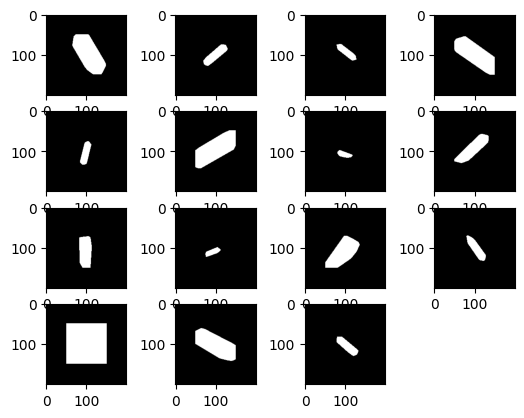

In [ ]:
from skimage.morphology import convex_hull_image


k=1


for i in cleaned_hsv_dataSet:
  #getting the contours of each image (the edges)
  contours, hierarchy = cv2.findContours(i, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  cnt = contours[0]
  convexHull = cv2.convexHull(cnt) #creating the convex hull
  i = cv2.drawContours(i, [convexHull], 0, (255, 0, 0), -7) #drawing our convex hull <- (-7) is the line width, value< 0 will fill it!!!!


#skimage approach
  #i = convex_hull_image(i)

# Display the final convex hull image
  plt.subplot(4,4,k)
  plt.imshow(i,cmap="gray")
  k+=1


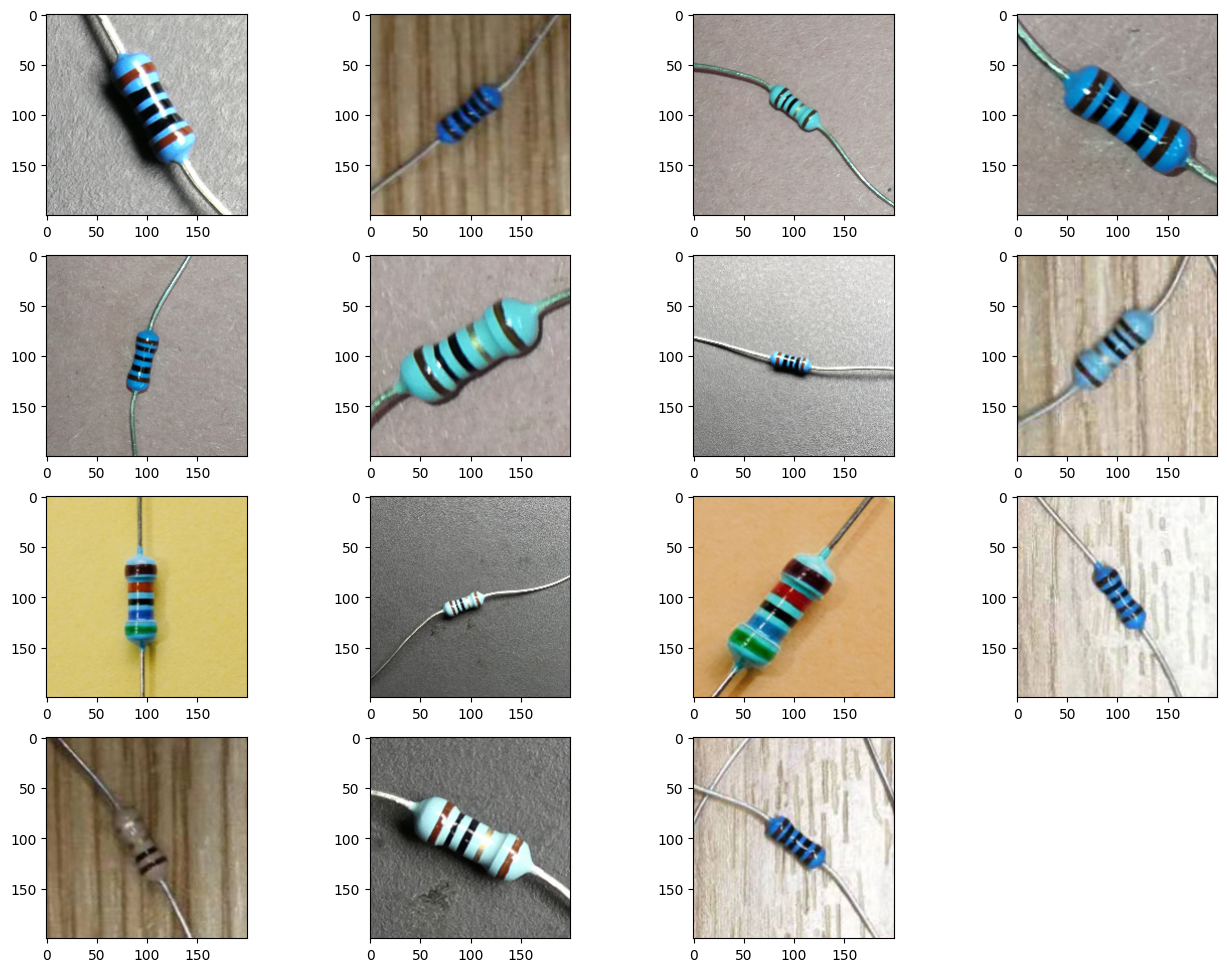

In [ ]:
k = 1
plt.figure(figsize=(16, 12))

for i in cleaned_hsv_dataSet:

  located_dataSet.append(dataSet[k-1])
  labels, nlabels = ndimage.label(closing)  # Label features in an array. Any non-zero values in input are counted as features and zero values are considered the background.

  centroid = ndimage.center_of_mass(cleaned_hsv_dataSet[k-1], labels, np.arange(nlabels) + 1 ) # calculate the center of mass of the values of an array at labels.

  plt.subplot(4,4,k)
  plt.imshow(located_dataSet[k-1][:,:,::-1])
  k+=1


Bounding Rectangles

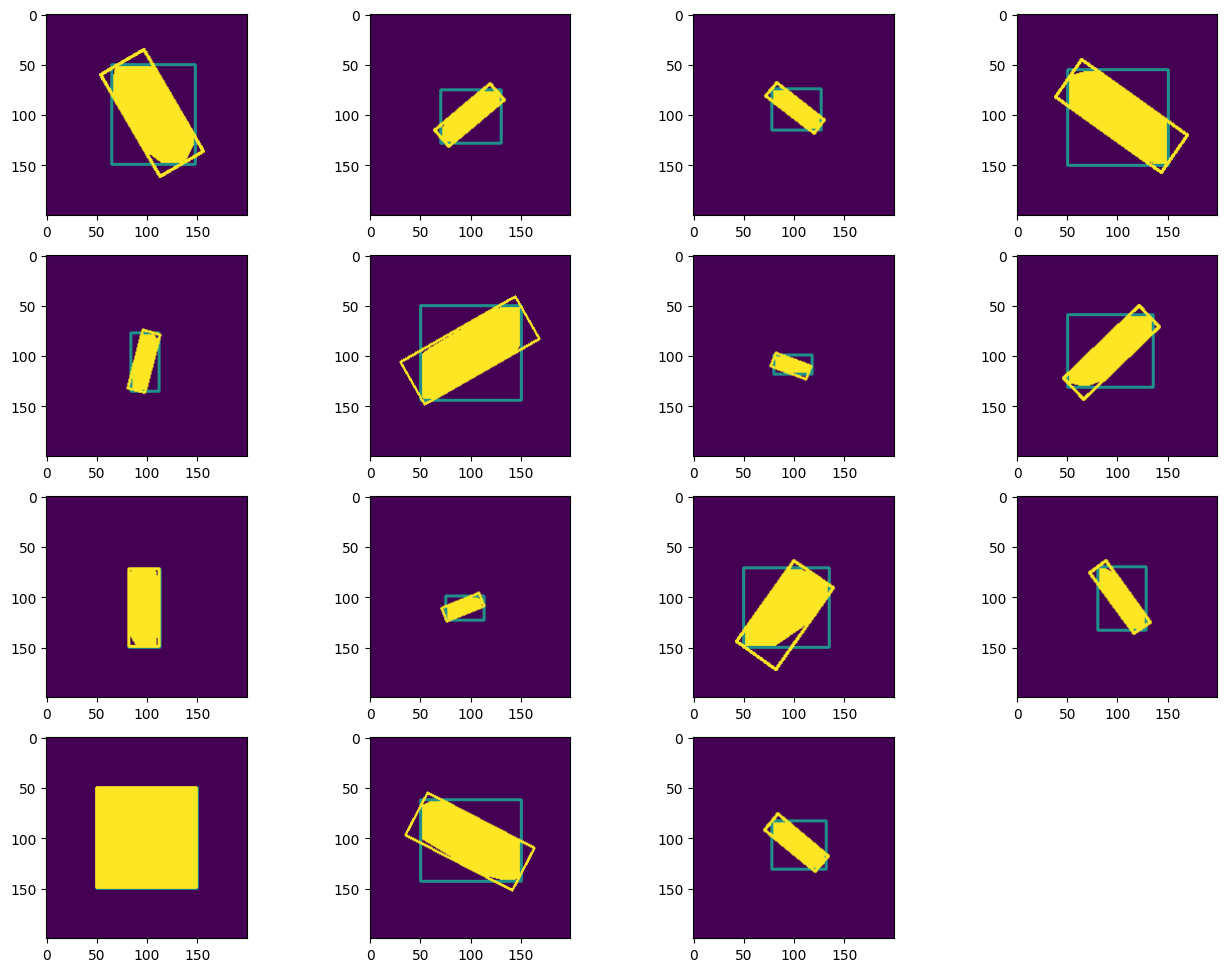

In [ ]:
k = 1
plt.figure(figsize=(16, 12))
for i in cleaned_hsv_dataSet:

  #getting the contours
  contours,hierarchy = cv2.findContours(i, 1, 2)
  cnt = contours[0]
  #setting the bounding box
  x,y,w,h = cv2.boundingRect(cnt)                                               #x,y <- top left vert coord, w,h <- width, height
  #setting the angular rectangle box
  rect = cv2.minAreaRect(cnt)
  box = cv2.boxPoints(rect)                                                     #returns the 4 verticies of the RECTANGLE!
  box = np.intp(box)
  #drawing the boxes on mask
  cv2.rectangle(i,(x,y),(x+w,y+h),(128, 0, 128),2)
  cv2.drawContours(i,[box],0, (255, 192, 203),2)
  #drawing boxes on original data set
  cv2.rectangle(dataSet[k-1],(x,y),(x+w,y+h),(128, 0, 128))
  cv2.drawContours(dataSet[k-1],[box],0, (255, 192, 203),2)

  #generating a fitted line
  #rows,cols = i.shape[:2] #using the shape of
  #[vx,vy,fx,fy] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
  #lefty = int((-fx*vy/vx) + fy)
  #righty = int(((cols-fx)*vy/vx)+fy)
  #cv2.line(i,(cols-1,righty),(0,lefty),(255,255,255),4)
  #drawing fitted line on original data set
  #cv2.line(dataSet[k-1],(cols-1,righty),(0,lefty),(255,255,255),4,)      <---- Dont want to add line to the original image

  #cropping to get our area of focus to extract colours
  area_of_focus_dataSet.append(y)
  area_of_focus_dataSet.append(y+h)
  area_of_focus_dataSet.append(x)
  area_of_focus_dataSet.append(x+w)

  plt.subplot(4,4,k)
  plt.imshow(i)

  k+=1


#helpful
#https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
#https://medium.com/analytics-vidhya/contours-and-convex-hull-in-opencv-python-d7503f6651bc
#https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0

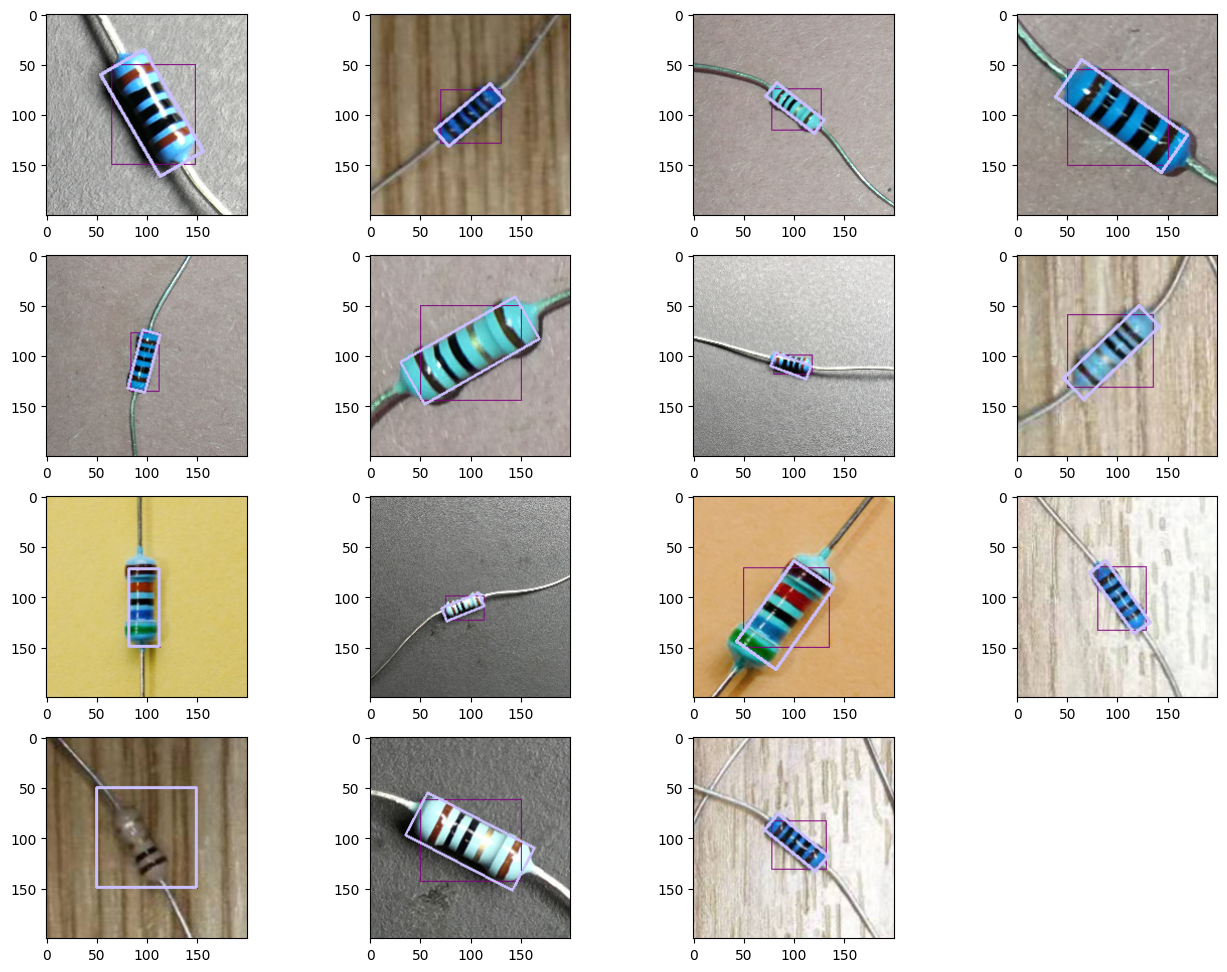

In [ ]:
k= 1
plt.figure(figsize=(16, 12))
for i in dataSet:
  plt.subplot(4,4,k)
  plt.imshow(i [:,:,::-1])
  k+=1


Bitwise Masking

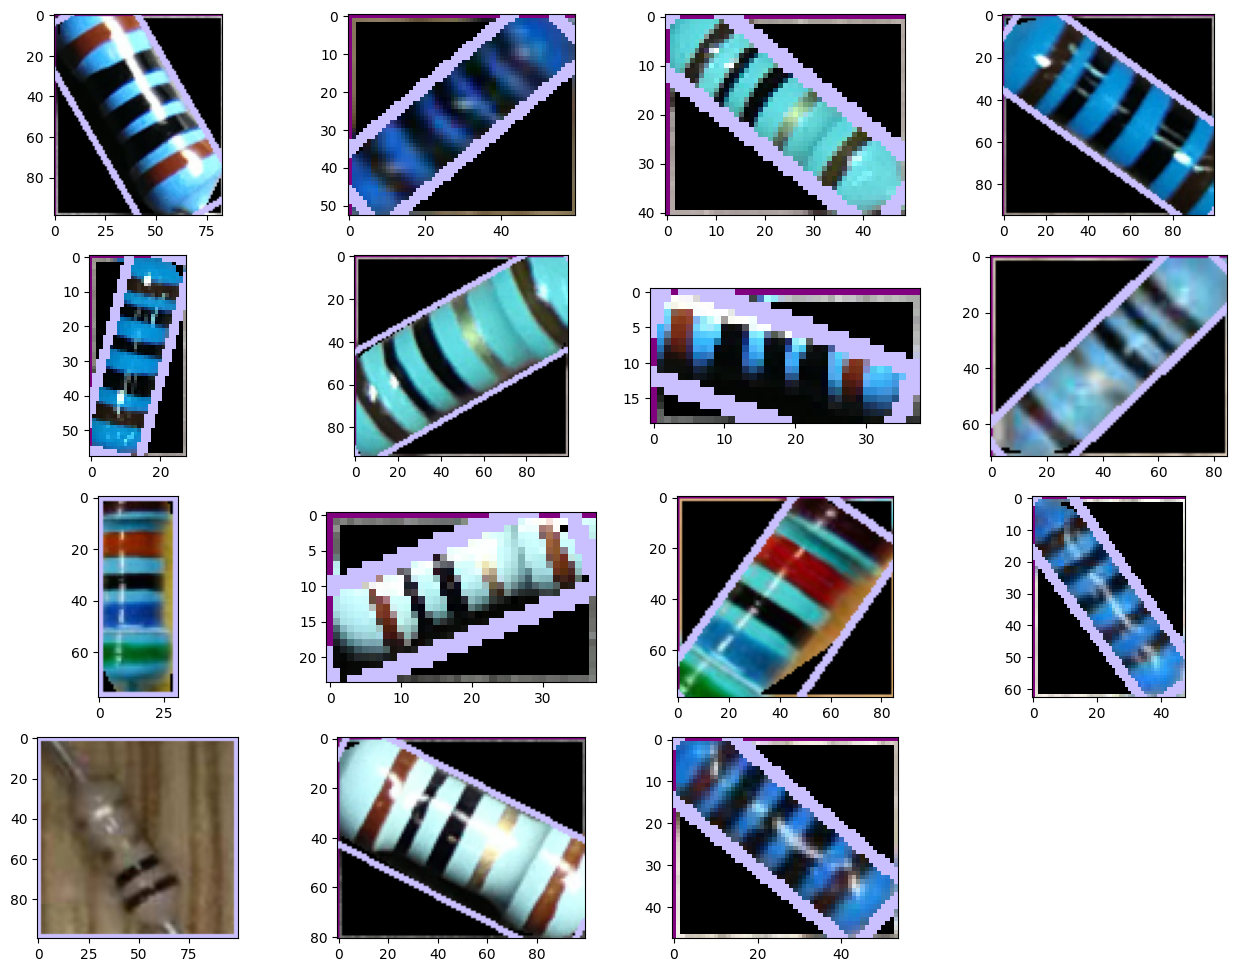

In [ ]:
k=1
index = 0
plt.figure(figsize=(16, 12))
for i in cleaned_hsv_dataSet:
  #creating the bitwise mask
  maskedImg = cv2.bitwise_and(dataSet[k-1],dataSet[k-1],mask = i)
  maskedImg = maskedImg[area_of_focus_dataSet[index]: area_of_focus_dataSet[index+1], area_of_focus_dataSet[index+2]: area_of_focus_dataSet[index+3]]

  plt.subplot(4,4,k)
  plt.imshow(maskedImg[:,:,::-1])
  index +=4
  k+=1
